In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
%matplotlib inline
from scipy import stats
import shap
import sys

import warnings
warnings.filterwarnings("ignore")

from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

from utils import *

## Loading data

In [2]:
path = ''
df_original = pd.read_csv(path + 'data/compas-scores-two-years.csv')
print(df_original.shape)
cols_name = ['race', 'age', 'c_charge_degree', 'v_score_text', 'sex', 
             'priors_count', 'days_b_screening_arrest', 'v_decile_score', 
             'two_year_recid']

df_original = df_original[cols_name]
df_original = df_original[(df_original['days_b_screening_arrest'] <= 30) &
                          (df_original['days_b_screening_arrest'] >= -30)]
print(df_original.shape)
df_original.head(2)

(7214, 53)
(6172, 9)


,race,age,c_charge_degree,v_score_text,sex,priors_count,days_b_screening_arrest,v_decile_score,two_year_recid
0,Other,69,F,Low,Male,0,-1.0,1,0
1,African-American,34,F,Low,Male,0,-1.0,1,1


In [3]:
df_original.two_year_recid = df_original.two_year_recid.replace({0:1, 1:0})
df_original.two_year_recid.value_counts()

1    3363
0    2809
Name: two_year_recid, dtype: int64

## Preprocessing

In [4]:
df_proces = df_original.copy()
df_proces = df_proces.fillna('0')
df_proces['race'] = df_proces['race'].apply(lambda row: 1 if row == 'Caucasian' else 0)

columns_cat = ['c_charge_degree', 'v_score_text', 'sex']
df_proces = pd.get_dummies(df_proces, columns=columns_cat)
df_proces = df_proces.astype(float)
df_proces.head()

,race,age,priors_count,days_b_screening_arrest,v_decile_score,two_year_recid,c_charge_degree_F,c_charge_degree_M,v_score_text_High,v_score_text_Low,v_score_text_Medium,sex_Female,sex_Male
0,0.0,69.0,0.0,-1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.0,34.0,0.0,-1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.0,24.0,4.0,-1.0,3.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
5,0.0,44.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
6,1.0,41.0,14.0,-1.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [5]:
metadata = {'label_maps': [{0.0: 'Bad', 1.0: 'Good'}], 
            'protected_attribute_maps': [{0.0: 'Not Caucasian', 1.0: 'Caucasian'}]}
unprivileged_groups=[{'race': [0.0]}]
privileged_groups=[{'race': [1.0]}]
protected_attribute_names = ['race']
label_names = ['two_year_recid']
dataset = BinaryLabelDataset(df = df_proces, label_names=label_names, 
                            protected_attribute_names = protected_attribute_names, 
                            instance_weights_name=None, unprivileged_protected_attributes=[], 
                            privileged_protected_attributes=[], metadata=metadata)

metric_orig = BinaryLabelDatasetMetric(dataset,
                                       unprivileged_groups=unprivileged_groups,
                                       privileged_groups=privileged_groups)
disparate_impact_orig = metric_orig.disparate_impact()
print('Disparate impact dados originais: ', (1 - disparate_impact_orig))
position = 0
name_protect = 'race'

Disparate impact dados originais:  0.15999247178213294


In [6]:
lst_res = []

## Model with original data

In [7]:
dataset_train, dataset_test = dataset.split([0.7], shuffle=False)

scale = StandardScaler().fit(dataset_train.features)  
X_train_orig = scale.transform(dataset_train.features)     
y_train = dataset_train.labels.ravel()
X_test_orig = scale.transform(dataset_test.features)   
y_test = dataset_test.labels.ravel()

### Random Forest

In [8]:
model_orig_rf = RandomForestClassifier(n_estimators=100, min_samples_split=10, max_depth=10)
model_orig_rf.fit(X_train_orig, y_train) 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [9]:
print('RESULT WITH RANDOM FOREST WITH ORIGINAL DATA: \n')

result = compute_metrics(model_orig_rf, X_test_orig, y_test, X_train_orig, y_train, 
                         dataset_test, 'compas', 'rf_orig', unprivileged_groups, 
                         privileged_groups, position)
lst_res.append(result)

RESULT WITH RANDOM FOREST WITH ORIGINAL DATA: 

Test accuracy:  0.6722462203023758
Train accuracy:  0.7587962962962963
Disparate impact:  0.7625976130838368
Mean difference:  -0.16902435314419384
Average odds difference: -0.13771313073528688
Equality of opportunity: -0.10527961484425863
False discovery rate difference: 0.04932157394843961
Generalized entropy index: 0.1435659660452371
Consistency:  0.9211663066954643


### Gradient Boosting

In [10]:
model_orig_gbm = GradientBoostingClassifier()
model_orig_gbm.fit(X_train_orig, y_train) 

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [11]:
print('RESULT WITH GRADIENT BOOSTING WITH ORIGINAL DATA: \n')

result = compute_metrics(model_orig_gbm, X_test_orig, y_test, X_train_orig, y_train, 
                         dataset_test, 'compas', 'gbm_orig', unprivileged_groups, 
                         privileged_groups, position)
lst_res.append(result)

RESULT WITH GRADIENT BOOSTING WITH ORIGINAL DATA: 

Test accuracy:  0.677645788336933
Train accuracy:  0.711574074074074
Disparate impact:  0.7418184550323613
Mean difference:  -0.1892495790782206
Average odds difference: -0.1563675783654016
Equality of opportunity: -0.12841808587191172
False discovery rate difference: 0.049173748120659444
Generalized entropy index: 0.13874908551991003
Consistency:  0.942656587473002


### Logistic Regression

In [12]:
model_orig_lr = LogisticRegression()
model_orig_lr.fit(X_train_orig, y_train) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [13]:
print('RESULT WITH LOGISTIC REGRESSION WITH ORIGINAL DATA: \n')

result = compute_metrics(model_orig_lr, X_test_orig, y_test, X_train_orig, y_train, 
                         dataset_test, 'compas', 'lr_orig', unprivileged_groups, 
                         privileged_groups, position)
lst_res.append(result)

RESULT WITH LOGISTIC REGRESSION WITH ORIGINAL DATA: 

Test accuracy:  0.6657667386609071
Train accuracy:  0.6826388888888889
Disparate impact:  0.781967073274759
Mean difference:  -0.16087866437978948
Average odds difference: -0.1317537994216597
Equality of opportunity: -0.09777524586231712
False discovery rate difference: 0.056130494776266526
Generalized entropy index: 0.13613278463648845
Consistency:  0.9558315334773217


## Model with transformed data

In [14]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
RW.fit(dataset_train)
dataset_transf_train = RW.transform(dataset_train)

In [15]:
metric_transf = BinaryLabelDatasetMetric(dataset_transf_train,
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
disparate_impact_transf = metric_transf.disparate_impact()
print('Disparate impact dados transformados: ', (1 - disparate_impact_transf))

Disparate impact dados transformados:  0.0


In [16]:
scale_transf = StandardScaler().fit(dataset_transf_train.features) 
X_train_transf = scale.transform(dataset_transf_train.features)  
y_train = dataset_transf_train.labels.ravel()
X_test_transf = scale_transf.transform(dataset_test.features) 
y_test = dataset_test.labels.ravel()

### Random Forest

In [17]:
model_transf_rf = RandomForestClassifier(n_estimators=100, min_samples_split=10, max_depth=10)
model_transf_rf.fit(X_train_transf, y_train,
                 sample_weight=dataset_transf_train.instance_weights)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [18]:
print('RESULT WITH RANDOM FOREST WITH TRANSFORMED DATA: \n')

result = compute_metrics(model_transf_rf, X_test_transf, y_test, X_train_transf, y_train, 
                         dataset_test, 'compas', 'rf_transf', unprivileged_groups, 
                         privileged_groups, position)
lst_res.append(result)

RESULT WITH RANDOM FOREST WITH TRANSFORMED DATA: 

Test accuracy:  0.6690064794816415
Train accuracy:  0.762962962962963
Disparate impact:  0.8282633088143623
Mean difference:  -0.11560269180133542
Average odds difference: -0.08296868809844482
Equality of opportunity: -0.059615186923894004
False discovery rate difference: 0.06568649373881935
Generalized entropy index: 0.14606538359821744
Consistency:  0.9114470842332614


### Gradient Boosting

In [19]:
model_transf_gbm = GradientBoostingClassifier()
model_transf_gbm.fit(X_train_transf, y_train,
                 sample_weight=dataset_transf_train.instance_weights)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [20]:
print('RESULT WITH GRADIENT BOOSTING WITH TRANSFORMED DATA: \n')

result = compute_metrics(model_transf_gbm, X_test_transf, y_test, X_train_transf, y_train, 
                         dataset_test, 'compas', 'gbm_transf', unprivileged_groups, 
                         privileged_groups, position)
lst_res.append(result)

RESULT WITH GRADIENT BOOSTING WITH TRANSFORMED DATA: 

Test accuracy:  0.6711663066954644
Train accuracy:  0.7131944444444445
Disparate impact:  0.8652555115111988
Mean difference:  -0.09048375845121759
Average odds difference: -0.055831501204536976
Equality of opportunity: -0.04216495905150264
False discovery rate difference: 0.07891986355463693
Generalized entropy index: 0.14017506036847727
Consistency:  0.9205183585313174


### Logistic Regression

In [21]:
model_transf_lr = LogisticRegression()
model_transf_lr.fit(X_train_transf, y_train,
                    sample_weight=dataset_transf_train.instance_weights)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [22]:
print('RESULT WITH LOGISTIC REGRESSION WITH TRANSFORMED DATA: \n')

result = compute_metrics(model_transf_lr, X_test_transf, y_test, X_train_transf, y_train, 
                         dataset_test, 'compas', 'lr_transf', unprivileged_groups, 
                         privileged_groups, position)
lst_res.append(result)

RESULT WITH LOGISTIC REGRESSION WITH TRANSFORMED DATA: 

Test accuracy:  0.6565874730021598
Train accuracy:  0.6821759259259259
Disparate impact:  1.000329997159518
Mean difference:  0.00020718268267483353
Average odds difference: 0.032951593156149955
Equality of opportunity: 0.04205787616077861
False discovery rate difference: 0.10100432324575986
Generalized entropy index: 0.14087442407607087
Consistency:  0.9056155507559396


In [23]:
cols_name = ['dataset', 'name_exp', 'acc_test', 'disp_impact_bin', 'mean_difference',
             'disp_impact_clf', 'avg_odds', 'equal_opport', 'false_discovery_rate', 
             'entropy_index', 'consistency']

df_final = pd.DataFrame(lst_res, columns=cols_name)
df_final

,dataset,name_exp,acc_test,disp_impact_bin,mean_difference,disp_impact_clf,avg_odds,equal_opport,false_discovery_rate,entropy_index,consistency
0,compas,rf_orig,0.672246,0.762598,-0.169024,0.762598,-0.137713,-0.105280,0.049322,0.143566,0.921166
1,compas,gbm_orig,0.677646,0.741818,-0.189250,0.741818,-0.156368,-0.128418,0.049174,0.138749,0.942657
2,compas,lr_orig,0.665767,0.781967,-0.160879,0.781967,-0.131754,-0.097775,0.056130,0.136133,0.955832
3,compas,rf_transf,0.669006,0.828263,-0.115603,0.828263,-0.082969,-0.059615,0.065686,0.146065,0.911447
4,compas,gbm_transf,0.671166,0.865256,-0.090484,0.865256,-0.055832,-0.042165,0.078920,0.140175,0.920518
5,compas,lr_transf,0.656587,1.000330,0.000207,1.000330,0.032952,0.042058,0.101004,0.140874,0.905616


## SHAP

In [24]:
lst_shape = []

### Random Forest

RESULTS WITH RANDOM FOREST WITH ORIGINAL DATA: 



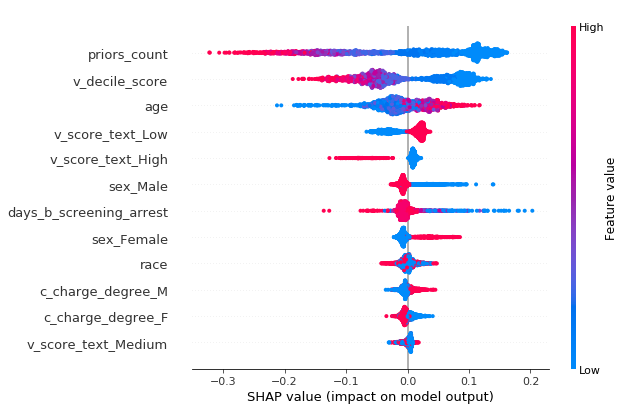

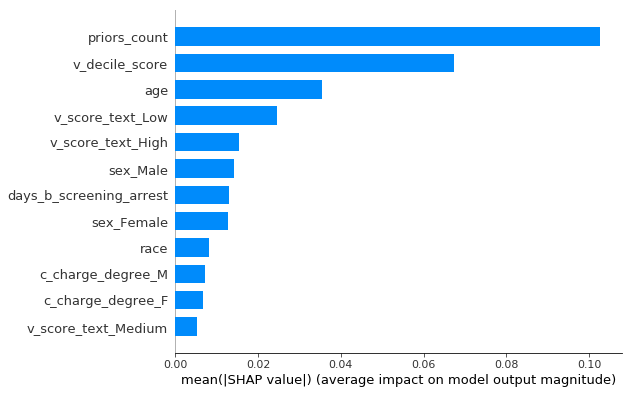

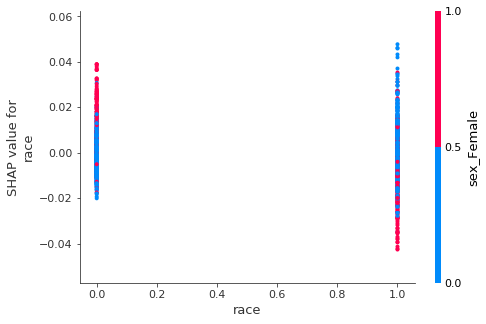

Mean SHAP value unprivileged class:  0.0009775738114241343
Mean SHAP value privileged class:  -0.00131605442111376
accept null hypothesis, mean of group privilegiad is NOT greater than mean of unprivilegiad


In [25]:
print('RESULTS WITH RANDOM FOREST WITH ORIGINAL DATA: \n')
df_feat, shap_results = tree_shap_results(model_orig_rf, 'rf_orig', X_train_orig, 
                                            X_test_orig, dataset_test, name_protect, position)
lst_shape.append(shap_results)

In [26]:
print('Global SHAP values by feature of Random Forest with original data: ')
df_feat

Global SHAP values by feature of Random Forest with original data: 


,feature_names,value
0,priors_count,0.102771
1,v_decile_score,0.067422
2,age,0.035365
3,v_score_text_Low,0.024635
4,v_score_text_High,0.015498
5,sex_Male,0.014205
6,days_b_screening_arrest,0.013085
7,sex_Female,0.012843
8,race,0.008153
9,c_charge_degree_M,0.007182


RESULTS WITH RANDOM FOREST WITH TRANSFORMED DATA: 



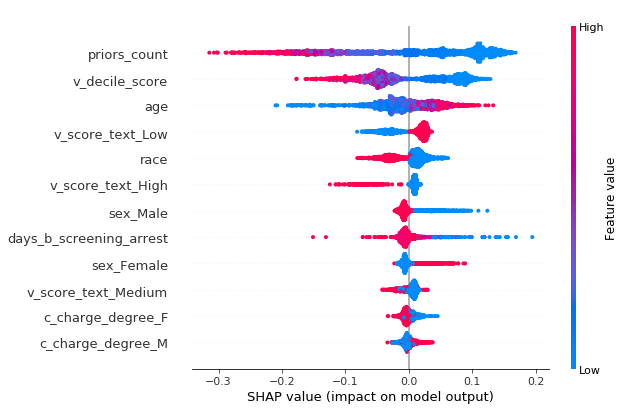

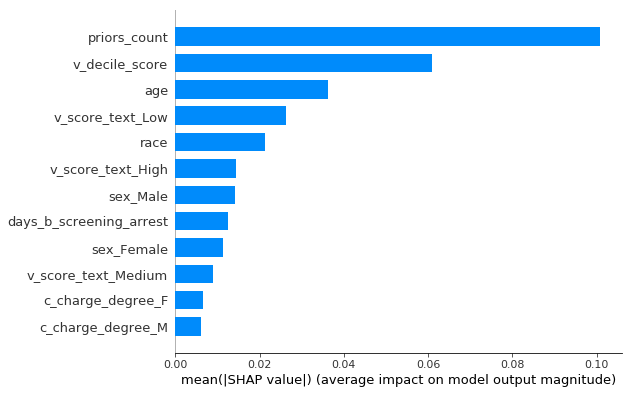

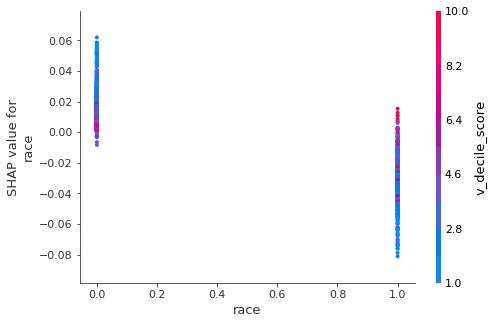

Mean SHAP value unprivileged class:  0.01650717918032934
Mean SHAP value privileged class:  -0.030194460259151415
accept null hypothesis, mean of group privilegiad is NOT greater than mean of unprivilegiad


In [27]:
print('RESULTS WITH RANDOM FOREST WITH TRANSFORMED DATA: \n')
df_feat, shap_results = tree_shap_results(model_transf_rf, 'rf_transf', X_train_transf, 
                                          X_test_transf, dataset_test, name_protect, 
                                          position)
lst_shape.append(shap_results)

In [28]:
print('Global SHAP values by feature of Random Forest with transformed data: ')
df_feat

Global SHAP values by feature of Random Forest with transformed data: 


,feature_names,value
0,priors_count,0.100903
1,v_decile_score,0.060972
2,age,0.036215
3,v_score_text_Low,0.026352
4,race,0.021213
5,v_score_text_High,0.014291
6,sex_Male,0.014273
7,days_b_screening_arrest,0.012450
8,sex_Female,0.011230
9,v_score_text_Medium,0.008880


### Gradient Boosting

RESULTS WITH GRADIENT BOOSTING WITH ORIGINAL DATA: 



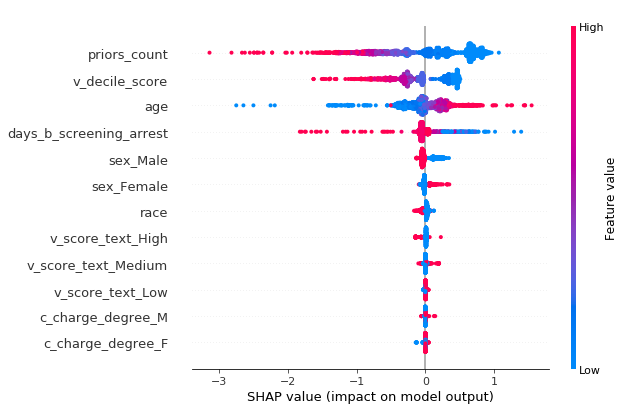

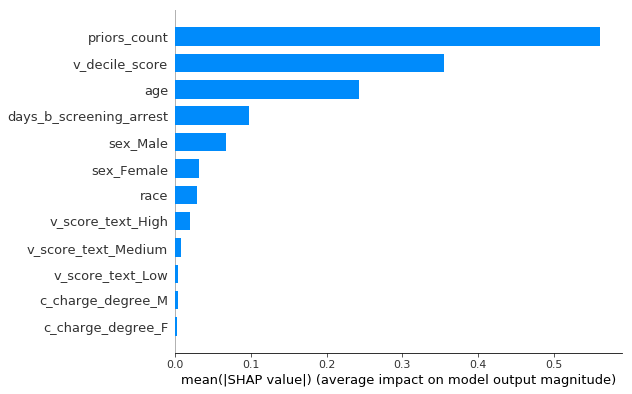

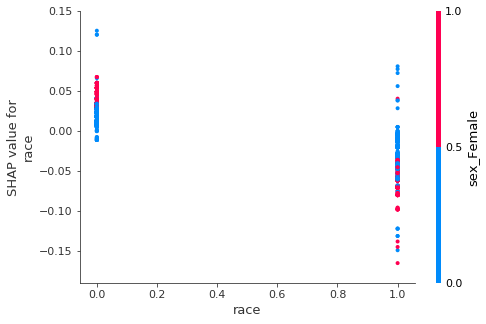

Mean SHAP value unprivileged class:  0.022917233890720517
Mean SHAP value privileged class:  -0.03891103836789163
accept null hypothesis, mean of group privilegiad is NOT greater than mean of unprivilegiad


In [29]:
print('RESULTS WITH GRADIENT BOOSTING WITH ORIGINAL DATA: \n')
df_feat, shap_results = tree_shap_results(model_orig_gbm, 'gbm_orig', X_train_orig, 
                                          X_test_orig, dataset_test, name_protect, position)
lst_shape.append(shap_results)

In [30]:
print('Global SHAP values by feature of Gradient Boosting with original data: ')
df_feat

Global SHAP values by feature of Gradient Boosting with original data: 


,feature_names,value
0,priors_count,0.561916
1,v_decile_score,0.354720
2,age,0.242640
3,days_b_screening_arrest,0.097961
4,sex_Male,0.067434
5,sex_Female,0.031190
6,race,0.028895
7,v_score_text_High,0.019806
8,v_score_text_Medium,0.007743
9,v_score_text_Low,0.003472


RESULTS WITH GRADIENT BOOSTING WITH TRANSFORMED DATA: 



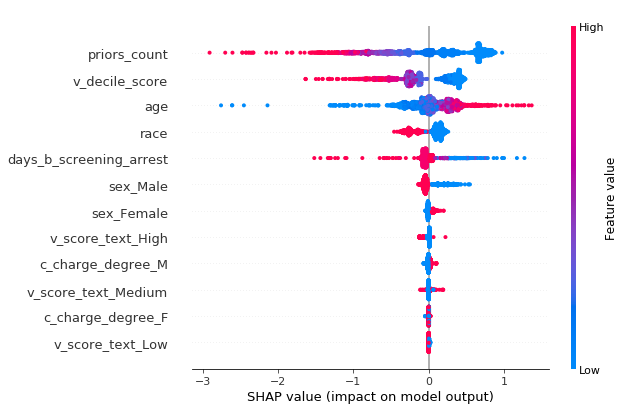

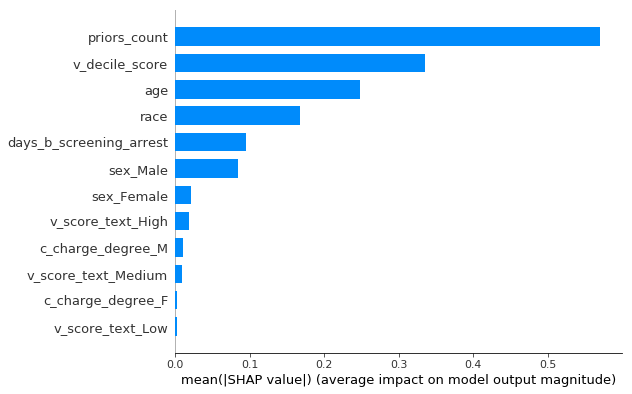

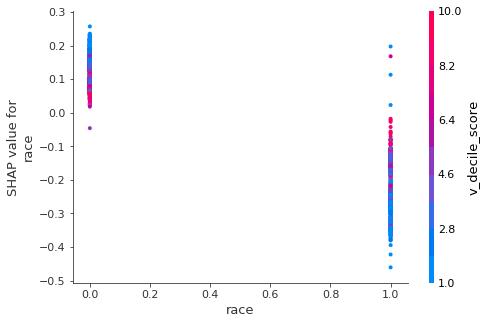

Mean SHAP value unprivileged class:  0.13181717762787465
Mean SHAP value privileged class:  -0.23528713626856407
accept null hypothesis, mean of group privilegiad is NOT greater than mean of unprivilegiad


In [31]:
print('RESULTS WITH GRADIENT BOOSTING WITH TRANSFORMED DATA: \n')
df_feat, shap_results = tree_shap_results(model_transf_gbm, 'gbm_transf', X_train_transf, 
                                          X_test_transf, dataset_test, name_protect, 
                                          position)
lst_shape.append(shap_results)

In [32]:
print('Global SHAP values by feature of Gradient Boosting with transformed data: ')
df_feat

Global SHAP values by feature of Gradient Boosting with transformed data: 


,feature_names,value
0,priors_count,0.570633
1,v_decile_score,0.335089
2,age,0.248075
3,race,0.166936
4,days_b_screening_arrest,0.094477
5,sex_Male,0.084062
6,sex_Female,0.020510
7,v_score_text_High,0.017860
8,c_charge_degree_M,0.010262
9,v_score_text_Medium,0.009055


### Logistic Regression

RESULTS WITH LOGISTIC REGRESION WITH ORIGINAL DATA: 



Estimating transforms: 100%|██████████| 1000/1000 [00:01<00:00, 551.32it/s]


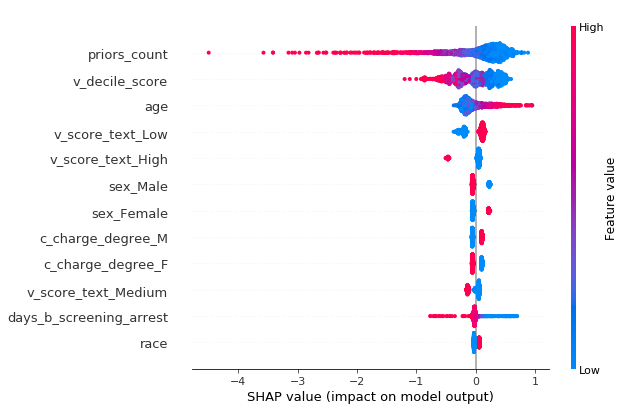

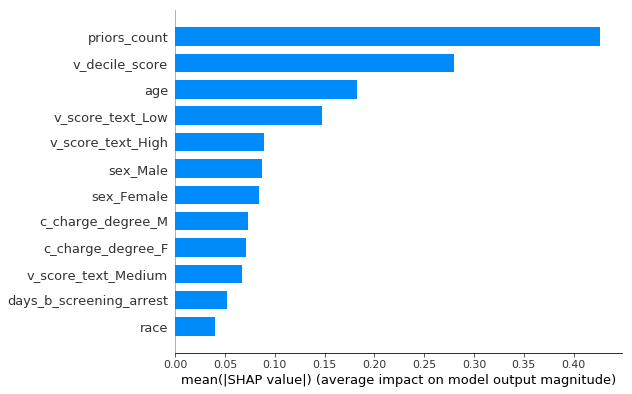

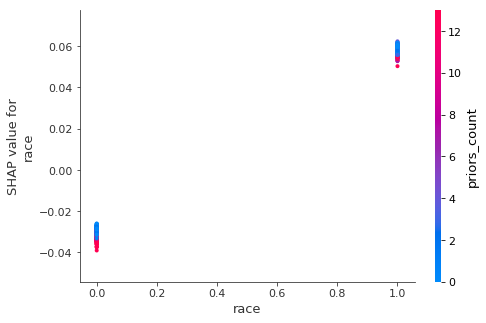

Mean SHAP value unprivileged class:  -0.030310907623133793
Mean SHAP value privileged class:  0.057744897014500675
reject null hypothesis, mean of group privilegiad is greater than mean of unprivilegiad


In [33]:
print('RESULTS WITH LOGISTIC REGRESION WITH ORIGINAL DATA: \n')
sys.stdout.flush()
df_feat, shap_results = linear_shap_results(model_orig_lr, 'lr_orig', X_train_orig, 
                                            X_test_orig, dataset_test, name_protect, 
                                            position)
lst_shape.append(shap_results)

In [34]:
print('Global SHAP values by feature of Logistic Regression with original data: ')
df_feat

Global SHAP values by feature of Logistic Regression with original data: 


,feature_names,value
0,priors_count,0.426997
1,v_decile_score,0.280121
2,age,0.182603
3,v_score_text_Low,0.147104
4,v_score_text_High,0.088994
5,sex_Male,0.086812
6,sex_Female,0.083725
7,c_charge_degree_M,0.072889
8,c_charge_degree_F,0.071228
9,v_score_text_Medium,0.066534


RESULTS WITH LOGISTIC REGRESION WITH TRANSFORMED DATA: 



Estimating transforms: 100%|██████████| 1000/1000 [00:02<00:00, 492.88it/s]


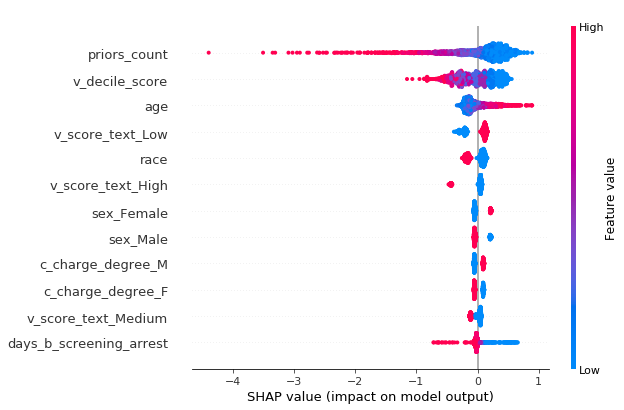

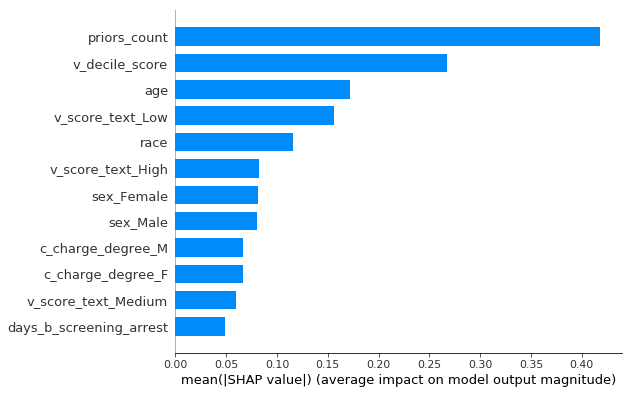

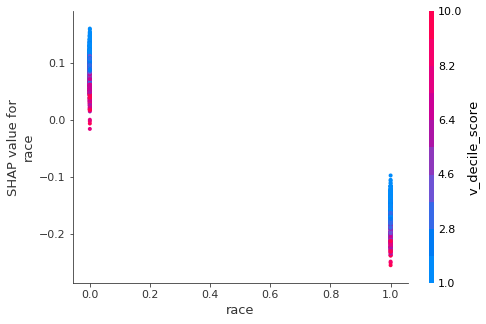

Mean SHAP value unprivileged class:  0.08815783008860967
Mean SHAP value privileged class:  -0.1703848015223062
accept null hypothesis, mean of group privilegiad is NOT greater than mean of unprivilegiad


In [35]:
print('RESULTS WITH LOGISTIC REGRESION WITH TRANSFORMED DATA: \n')
sys.stdout.flush()
df_feat, shap_results = linear_shap_results(model_transf_lr, 'lr_transf', X_train_transf, 
                                            X_test_transf, dataset_test, name_protect, 
                                            position)
lst_shape.append(shap_results)

In [36]:
print('Global SHAP values by feature of Logistic Regression with transformed data: ')
df_feat

Global SHAP values by feature of Logistic Regression with transformed data: 


,feature_names,value
0,priors_count,0.418346
1,v_decile_score,0.267648
2,age,0.172159
3,v_score_text_Low,0.155768
4,race,0.115623
5,v_score_text_High,0.082384
6,sex_Female,0.081801
7,sex_Male,0.080394
8,c_charge_degree_M,0.066821
9,c_charge_degree_F,0.066428


### Final result

In [37]:
df_shap = pd.DataFrame(lst_shape, columns=['name_exp', 'feat_imp', 'shap_rank', 'mean_unpriv', 'mean_priv', 
                                           'priv_greater_unpriv'])
df_final = pd.merge(df_shap, df_final, on='name_exp')
df_final

,name_exp,feat_imp,shap_rank,mean_unpriv,mean_priv,priv_greater_unpriv,dataset,acc_test,disp_impact_bin,mean_difference,disp_impact_clf,avg_odds,equal_opport,false_discovery_rate,entropy_index,consistency
0,rf_orig,0.008153,8,0.000978,-0.001316,0,compas,0.672246,0.762598,-0.169024,0.762598,-0.137713,-0.105280,0.049322,0.143566,0.921166
1,rf_transf,0.021213,4,0.016507,-0.030194,0,compas,0.669006,0.828263,-0.115603,0.828263,-0.082969,-0.059615,0.065686,0.146065,0.911447
2,gbm_orig,0.028895,6,0.022917,-0.038911,0,compas,0.677646,0.741818,-0.189250,0.741818,-0.156368,-0.128418,0.049174,0.138749,0.942657
3,gbm_transf,0.166936,3,0.131817,-0.235287,0,compas,0.671166,0.865256,-0.090484,0.865256,-0.055832,-0.042165,0.078920,0.140175,0.920518
4,lr_orig,0.039465,11,-0.030311,0.057745,1,compas,0.665767,0.781967,-0.160879,0.781967,-0.131754,-0.097775,0.056130,0.136133,0.955832
5,lr_transf,0.115623,4,0.088158,-0.170385,0,compas,0.656587,1.000330,0.000207,1.000330,0.032952,0.042058,0.101004,0.140874,0.905616


In [38]:
df_final.to_csv(path + 'result/resultado_compas.csv')